# Functions

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Functions for binning (discreetising) numeric fields

def distance_binning(dataset, field, no_of_bins):
    
    # Buckets numerical field data into equally sized bucket thresholds
    # Returns updated dataframe
    
    # Inputs: 
    #    dataset:     Pandas dataframe containing dataset 
    #    field:       Field to be binned
    #    no_of_bins:  Required number of bins
    
    bins = np.linspace(dataset[field].min(),dataset[field].max(),no_of_bins+1)
    labels = [i for i in range(1,no_of_bins+1)]
    dataset_new = dataset.copy()
    dataset_new[field] = pd.cut(dataset_new[field], bins=bins, labels=labels, include_lowest=True)
    return dataset_new

def frequency_binning(dataset, field, no_of_bins):
    
    # Buckets numerical field data into buckets containing roughly equal number of records
    # Returns updated dataframe
    
    # Inputs: 
    #    dataset:     Pandas dataframe containing dataset 
    #    field:       Field to be binned
    #    no_of_bins:  Required number of bins
    
    labels = [i for i in range(1,no_of_bins+1)]
    dataset_new = dataset.copy()
    dataset_new[field] = pd.qcut(dataset_new[field], q=no_of_bins, labels=labels)
    return dataset_new


# Normalises the dataset
# you have to remove all non-numerical columns before you call this function
# data : the dataset you want to normalise 
# omit : colums to omit from the normalisation (as a 1d list)
def NormaliseDS(data, omit=[]):
    if (len(omit)>0):
        temp = data[omit]
        data = data.drop(columns=omit, axis=1)
    column = list(data.columns)
    transform = MinMaxScaler().fit_transform(data)
    newDF = pd.DataFrame(transform, columns=column)
    if (len(omit)>0):
        dataF = pd.concat([newDF, temp], axis=1)
        return(dataF)
    else:
        return(newDF)

# standardises the dataset
# you have to remove all non-numerical columns before you call this function
# data : the dataset you want to standardise
def StandardiseDS(data, omit=[]):
    if (len(omit)>0):
        temp = data[omit]
        data = data.drop(columns=omit, axis=1)
    column = list(data.columns)
    strdDS = StandardScaler().fit_transform(data)
    strdDF = pd.DataFrame(strdDS, columns=column)
    if (len(omit)>0):
        dataF = pd.concat([strdDF, temp], axis=1)
        return(dataF)
    else:
        return(strdDF)

# renames the column names in a dataset so it is one word instead of a space
# data : the dataset you want to rename 
# cols : a dictionary of the current columns you want to rename and the name you want to rename it to (new name should have no spaces)
def RenameFields(data, cols):
    data2 = data.rename(columns=cols)
    return(data2)

# this fucntion divides the possible results of the dataset (ie the quality of a wine) and up-samples the dataset so the data is balanced
# dataset (dataframe) : the dataset you want to up-sample
# targetClass (string) : the name of the column that has the results
# startPoint (int) : the lowest class by number in the dataset(for wine lowest quality is 3, Highest quality is 9 )
# biggestClass (int) : the class that has the highest number of rows
def OverSample (dataset, targetClass, startPoint, biggestClass):
    temp = []
    temp2 = []
    loopRange = (startPoint + len(dataset[targetClass].value_counts()))
    for i in range(startPoint, loopRange):
        temp.append(dataset[dataset[targetClass] == i])
    for j in temp:
        temp2.append(j.sample(len(temp[(biggestClass-startPoint)]), replace=True))
        
    final = pd.concat(temp2)
    return(final)


# Pre-Processing

In [3]:
# Loads the datasets
wine = pd.read_csv('winequalityN.csv')
mushrooms = pd.read_csv('mushrooms.csv')

# renames the columns
dsCols = {'fixed acidity': 'fixed-acidity', 'volatile acidity': 'volatile-acidity', 'citric acid': 'citric-acid', 'residual sugar':'residual-sugar', 'free sulfur dioxide':'free-sulfur-dioxide', 'total sulfur dioxide':'total-sulfur-dioxide'}
wine = RenameFields(wine, dsCols)

################ NULL Checks ################
print(mushrooms.isnull().sum())
print(wine.isnull().sum())
# removes rows with null values
wine = wine.dropna()


mushroomsTemp = mushrooms['class'].replace(['p', 'e'],[1, 0])
mushrooms.drop('class', inplace=True, axis=1)
mushrooms = pd.concat([mushrooms, mushroomsTemp], axis=1)
print(mushrooms)

################ Normalisation and Standardisation ################

# temp removes the worded fields
wineTemp = wine['type'].replace(['white', 'red'],[1, 0])   # binary encodes white and red wine types (white=1, red=0)
wine.drop('type', inplace=True, axis=1)
wine = pd.concat([wine, wineTemp], axis=1)
print(wine)

#normalises the dataset (omit is used to remove colums that do not need to be normalised ie bool, one hot, etc)
normalwine = NormaliseDS(wine, omit=['quality', 'type'])
#standardises the dataset (omit is used to remove colums that do not need to be normalised ie bool, one hot, etc)
standardwine = StandardiseDS(normalwine, omit=['quality', 'type'])
print("standard")
print(standardwine)


################ Balancing ################                COULD ALSO TRY BUCKTING TO BALANCE THE DATA

# prints the distribution of wine quality (quality is between 3 and 9, has most of the wines inbetween )
print(standardwine.quality.value_counts())      # Doing this we can see that the lowest quality is 3 (so that is the startPoint), and the class with the most rows is 6 (so 6 is the biggestClass)

balancedDataWine = OverSample(standardwine, 'quality', startPoint=3, biggestClass=6)
print(balancedDataWine.quality.value_counts())     # we can now see that the results are up Sampled to match the biggest dataset

# balancing for mushroom dataset (MUSHROOMS IS ALREADY KINDA BALANCED)
print(mushrooms['class'].value_counts())      # dataset is already balanced enough
 


######## OPTIONAL Wine Binning ########
#wine_data = pd.read_csv('winequalityN.csv')

#wine_data_binned = distance_binning(wine_data, 'pH', 5)
#print("Value counts")
#print(wine_data_binned['pH'].value_counts())
#print("\nBucket Min Max Size")
#for i in wine_data_binned['pH'].unique():
#    max = wine_data[wine_data_binned['pH']==i]['pH'].max()
#    min = wine_data[wine_data_binned['pH']==i]['pH'].min()  
#    print(str(i) + " " + str(min) + " " + str(max) + " " + str(round(max-min,2)))
    
    
#wine_data_binned = frequency_binning(wine_data, 'pH', 5)
#print("Value counts")
#print(wine_data_binned['pH'].value_counts())
#print("\nBucket Min Max Size")
#for i in wine_data_binned['pH'].unique():
#    max = wine_data[wine_data_binned['pH']==i]['pH'].max()
#    min = wine_data[wine_data_binned['pH']==i]['pH'].min()  
#    print(str(i) + " " + str(min) + " " + str(max) + " " + str(round(max-min,2)))


############### Mushroom Dataset Encoding ###############
# list of headinds that need to be one hot encoded
prefixList = ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'gill-attachment', 'gill-spacing', 'gill-size', 
              'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 
              'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-color', 'ring-number', 'ring-type', 
              'spore-print-color', 'population', 'habitat']

# veil-type column is not taken forward because each row has the same values making it useless for the models
mushroomsNew = mushrooms['class'] # the first enoded column (poisonus = 1, edible = 2)
# loop to convert onehot for all relevent 
for pref in prefixList:
    tempEncode = pd.get_dummies(mushrooms[pref], prefix=pref)
    mushroomsNew = pd.concat([mushroomsNew, tempEncode], axis=1)
#print(mushroomsNew.head())
# saves new datasets
mushroomsNew.to_csv('newMushroom.csv', index=False)
balancedDataWine.to_csv('newWine.csv', index=False)


class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64
type                     0
fixed-acidity           10
volatile-acidity         8
citric-acid              3
residual-sugar           2
chlorides                2
free-sulfur-dioxide      0
total-sulfur-dioxide     0
density                  0
pH                       9
sulphates                4


[5 rows x 108 columns]


### Extracting Dependent and Independent variables

In [4]:
y= mushroomsNew.iloc[:, :1]
y= np.ravel(y)
X=mushroomsNew.iloc[:, 1:].values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

### Stratified KFold Validation

In [7]:
from sklearn.svm import SVC
linear_ = SVC(kernel='linear', probability=True)
rbf_ = SVC(kernel='rbf', gamma='auto', probability=True)
poly_ = SVC(kernel='poly', probability=True)
sig_ = SVC(kernel='sigmoid', probability=True)

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

kfold = StratifiedKFold(n_splits=10)
linear_results = cross_validate(linear_, X_train, y_train, cv=kfold, scoring = {'accuracy' : make_scorer(accuracy_score),
'precision' : make_scorer(precision_score, average = 'weighted'),
'recall' : make_scorer(recall_score, average = 'weighted'),
'f1_score' : make_scorer(f1_score, average = 'weighted')})

rbf_results = cross_validate(rbf_, X_train, y_train, cv=kfold, scoring = {'accuracy' : make_scorer(accuracy_score),
'precision' : make_scorer(precision_score, average = 'weighted'),
'recall' : make_scorer(recall_score, average = 'weighted'),
'f1_score' : make_scorer(f1_score, average = 'weighted')})

poly_results = cross_validate(poly_, X_train, y_train, cv=kfold, scoring = {'accuracy' : make_scorer(accuracy_score),
'precision' : make_scorer(precision_score, average = 'weighted'),
'recall' : make_scorer(recall_score, average = 'weighted'),
'f1_score' : make_scorer(f1_score, average = 'weighted')})

sig_results = cross_validate(sig_, X_train, y_train, cv=kfold, scoring = {'accuracy' : make_scorer(accuracy_score),
'precision' : make_scorer(precision_score, average = 'weighted'),
'recall' : make_scorer(recall_score, average = 'weighted'),
'f1_score' : make_scorer(f1_score, average = 'weighted')})

### Regular Model training

In [6]:
from sklearn.svm import SVC
linear = SVC(kernel='linear', probability=True).fit(X_train, y_train)
rbf = SVC(kernel='rbf', gamma='auto', probability=True).fit(X_train, y_train)
poly = SVC(kernel='poly', probability=True).fit(X_train, y_train)
sig = SVC(kernel='sigmoid', probability=True).fit(X_train, y_train)

In [8]:
linear_pred = linear.predict(X_test)
poly_pred = poly.predict(X_test)
rbf_pred = rbf.predict(X_test)
sig_pred = sig.predict(X_test)

Accuracy Linear Kernel: 1.0
Accuracy Polynomial Kernel: 1.0
Accuracy Radial Basis Kernel: 0.9950763170851797
Accuracy Sigmoid Kernel: 0.8906942392909897


### Confusion Matrix

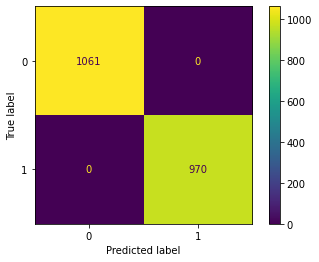

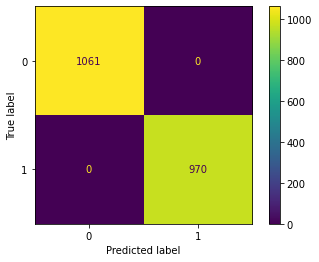

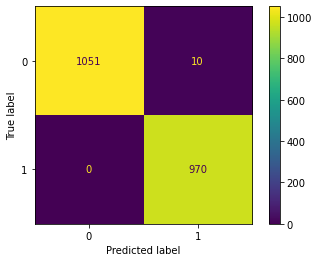

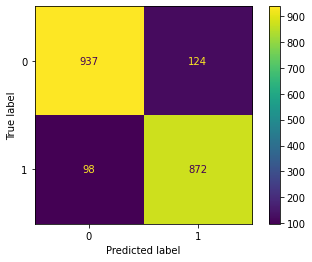

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_lin = confusion_matrix(y_test, linear_pred)
cm_poly = confusion_matrix(y_test, poly_pred)
cm_rbf = confusion_matrix(y_test, rbf_pred)
cm_sig = confusion_matrix(y_test, sig_pred)

cpl= ConfusionMatrixDisplay(confusion_matrix= cm_lin, display_labels=linear.classes_)
cpp= ConfusionMatrixDisplay(confusion_matrix= cm_poly, display_labels=poly.classes_)
cpr= ConfusionMatrixDisplay(confusion_matrix= cm_rbf, display_labels=rbf.classes_)
cps= ConfusionMatrixDisplay(confusion_matrix= cm_sig, display_labels=sig.classes_)

cpl.plot()
cpp.plot()
cpr.plot()
cps.plot()

### Evaluation Metrics

In [11]:
from sklearn import metrics
accuracy= metrics.accuracy_score(y_test, linear_pred)
precision= metrics.precision_score(y_test, linear_pred)
recall= metrics.recall_score(y_test, linear_pred)
fscore= 2 * ((precision * recall)/ (precision + recall))
print("-----------------LINEAR SVM EVALUATION METRICS--------------")
print("Accuracy:", round(accuracy,2))
print("StratifoldKFoldAccuracy:", str(round(linear_results['test_accuracy'].mean(), 2))+ str(' +/-') + str(round(linear_results['test_accuracy'].std(), 3)))
print("StratifoldKFoldf1score: ", str(round(linear_results['test_f1_score'].mean(), 2)) + str(' +/-') + str(round(linear_results['test_f1_score'].std(), 3)))
print("F-score: ", round(fscore, 2))

-----------------LINEAR SVM EVALUATION METRICS--------------
Accuracy: 1.0
StratifoldKFoldAccuracy: 1.0 +/-0.0
StratifoldKFoldf1score:  1.0 +/-0.0
F-score:  1.0


In [12]:
from sklearn import metrics
accuracy= metrics.accuracy_score(y_test, poly_pred)
precision= metrics.precision_score(y_test, poly_pred)
recall= metrics.recall_score(y_test, poly_pred)
fscore= 2 * ((precision * recall)/ (precision + recall))
print("-----------------POLYNOMIAL SVM EVALUATION METRICS--------------")
print("Accuracy:", round(accuracy,2))
print("StratifoldKFoldAccuracy:", str(round(poly_results['test_accuracy'].mean(), 2))+ str(' +/-') + str(round(poly_results['test_accuracy'].std(), 3)))
print("StratifoldKFoldf1score: ", str(round(poly_results['test_f1_score'].mean(), 2)) + str(' +/-') + str(round(poly_results['test_f1_score'].std(), 3)))
print("F-score: ", round(fscore, 2))

-----------------POLYNOMIAL SVM EVALUATION METRICS--------------
Accuracy: 1.0
StratifoldKFoldAccuracy: 1.0 +/-0.0
StratifoldKFoldf1score:  1.0 +/-0.0
F-score:  1.0


In [13]:
from sklearn import metrics
accuracy= metrics.accuracy_score(y_test, rbf_pred)
precision= metrics.precision_score(y_test, rbf_pred)
recall= metrics.recall_score(y_test, rbf_pred)
fscore= 2 * ((precision * recall)/ (precision + recall))
print("-----------------RBF SVM EVALUATION METRICS--------------")
print("Accuracy:", round(accuracy,2))
print("StratifoldKFoldAccuracy:", str(round(rbf_results['test_accuracy'].mean(), 2))+ str(' +/-') + str(round(rbf_results['test_accuracy'].std(), 3)))
print("StratifoldKFoldf1score: ", str(round(rbf_results['test_f1_score'].mean(), 2)) + str(' +/-') + str(round(rbf_results['test_f1_score'].std(), 3)))
print("F-score: ", round(fscore, 2))

-----------------RBF SVM EVALUATION METRICS--------------
Accuracy: 1.0
StratifoldKFoldAccuracy: 0.99 +/-0.003
StratifoldKFoldf1score:  0.99 +/-0.003
F-score:  0.99


In [14]:
from sklearn import metrics
accuracy= metrics.accuracy_score(y_test, sig_pred)
precision= metrics.precision_score(y_test, sig_pred)
recall= metrics.recall_score(y_test, sig_pred)
fscore= 2 * ((precision * recall)/ (precision + recall))
print("-----------------SIGMOID SVM EVALUATION METRICS--------------")
print("Accuracy:", round(accuracy,2))
print("StratifoldKFoldAccuracy:", str(round(sig_results['test_accuracy'].mean(), 2))+ str(' +/-') + str(round(sig_results['test_accuracy'].std(), 3)))
print("StratifoldKFoldf1score: ", str(round(sig_results['test_f1_score'].mean(), 2)) + str(' +/-') + str(round(sig_results['test_f1_score'].std(), 3)) )
print("F-score: ", round(fscore, 2))

-----------------SIGMOID SVM EVALUATION METRICS--------------
Accuracy: 0.89
StratifoldKFoldAccuracy: 0.89 +/-0.012
StratifoldKFoldf1score:  0.89 +/-0.012
F-score:  0.89


### ROC Curves

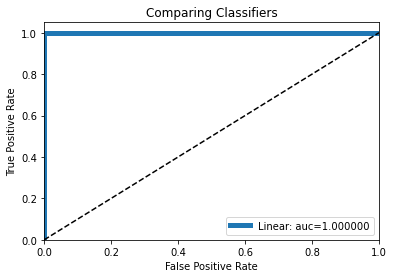

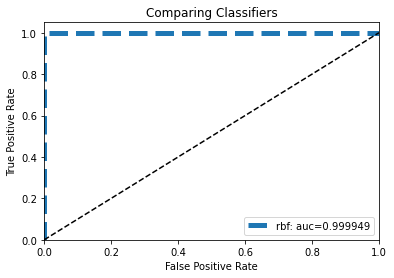

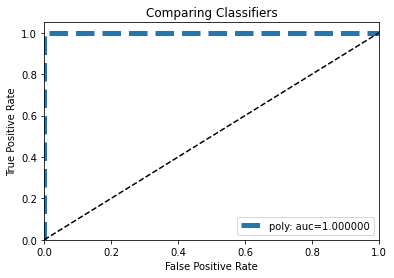

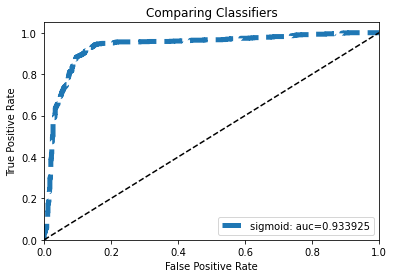

In [10]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import roc_curve, auc
CLASS_MAP= {'Linear': ('-', SVC(kernel='linear', probability=True)), 
            'rbf':('--', SVC(kernel='rbf', gamma='auto',  probability=True)),
            'poly':('--', SVC(kernel='poly',   probability=True)),
            'sigmoid':('--', SVC(kernel='sigmoid', probability=True))}
for name, (line_fmt, model) in CLASS_MAP.items():
    model.fit(X_train, y_train)
    preds= model.predict_proba(X_test)
    pred= pd.Series(preds[:,1])
    fpr, tpr, thresholds= roc_curve(y_test, pred)
    auc_score= auc(fpr, tpr)
    label='%s: auc=%f' % (name, auc_score)
    plt.plot(fpr, tpr, line_fmt, linewidth=5, label=label)
    plt.legend(loc='lower right')
    plt.title('Comparing Classifiers')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()